# ImageJ with Python Kernel

This notebook covers how to use ImageJ as a library from Python. A major advantage of this approach is the ability to combine ImageJ with other tools available from the Python software ecosystem, including [NumPy](https://www.numpy.org/), [SciPy](https://www.scipy.org/), [scikit-image](https://scikit-image.org/), [CellProfiler](https://cellprofiler.org/), [OpenCV](https://opencv.org/), [ITK](https://itk.org/) and more.

This notebook assumes familiarity with the ImageJ API. Detailed tutorials in that regard can be found in the [other notebooks](../ImageJ-Tutorials-and-Demo.ipynb).

## Starting ImageJ from Python

The [pyimagej](https://pypi.org/project/pyimagej/) module enables access to the entire ImageJ API from Python in a natural way.

Let's initialize an ImageJ gateway including Fiji plugins, at a reproducible version:

In [1]:
import imagej
ij = imagej.init('sc.fiji:fiji:2.0.0-pre-10')
ij.getVersion()

'2.0.0-rc-71/1.52i'

### Ways to initialize

| Requirement                                   | Code<sup>1</sup>                                                     | Reproducible?<sup>2</sup> |
|:----------------------------------------------|:---------------------------------------------------------------------|:-------------------------:|
| Newest available version of ImageJ            | `ij = imagej.init()`                                                 | NO                        |
| Specific version of ImageJ                    | `ij = imagej.init('net.imagej:imagej:2.0.0-rc-71')`                  | YES                       |
| With a GUI (newest version)                   | `ij = imagej.init(headless=False)`                                   | NO                        |
| With a GUI (specific version)                 | `ij = imagej.init('net.imagej:imageJ:2.0.0-rc-71', headless=False)`  | YES                       |
| With support for ImageJ 1.x (newest versions) | `ij = imagej.init('net.imagej:imagej+net.imagej:imagej-legacy')`     | NO                        |
| With Fiji plugins (newest version)            | `ij = imagej.init('sc.fiji:fiji')`                                   | NO                        |
| With Fiji plugins (specific version)          | `ij = imagej.init('sc.fiji:fiji:2.0.0-pre-10')`                      | YES                       |
| From a local installation                     | `ij = imagej.init('/Applications/Fiji.app')`                         | DEPENDS                   |

<sup>1</sup> pyimagej uses [`jgo`](https://github.com/scijava/jgo) internally to call up ImageJ, so all of these initializations are tied to the usage of `jgo`. You can read up on the [usage of `jgo`](https://github.com/scijava/jgo#usage) to find out more about this initialization.

<sup>2</sup> ___Reproducible___ means code is stable, executing the same today, tomorrow, and in years to come. While it is convenient and elegant to depend on the newest version of a program, behavior may change when new versions are released—for the better if bugs are fixed; for the worse if bugs are introduced—and people executing your notebook at a later time may encounter broken cells, unexpected results, or other more subtle behavioral differences. You can help avoid this pitfall by pinning to a specific version of the software. The British Ecological Society published [Guide to Better Science: Reproducible Code](https://www.britishecologicalsociety.org/wp-content/uploads/2018/12/BES-Reproducible-Code.pdf) diving into the relevant challenges in more detail, including an [R](https://www.r-project.org/)-centric illustration of best practices. A web search for `reproducible python` also yields several detailed articles.

### Increasing the memory available to Java

Java's virtual machine (the JVM) has a "max heap" value limiting how much
memory it can use. You can increase it:

```python
import scyjava.config
scyjava.config.add_options('-Xmx6g')
import imagej
ij = imagej.init()
```

Replace `6g` with the amount of memory Java should have. You can also pass
[other JVM arguments](https://docs.oracle.com/javase/8/docs/technotes/tools/unix/java.html).

Without having specified the max heap value explicitly, here is how much memory this notebook's JVM has available:

In [2]:
ij.getApp().getInfo(True)

'ImageJ 2.0.0-rc-71/1.52i; Java 1.8.0_192 [amd64]; 120MB of 3609MB'

## A simple example: `ij.py.show()`

ImageJ can display numpy images using `ij.py.show`. Let's demonstrate using `scikit-image` to grab a sample:

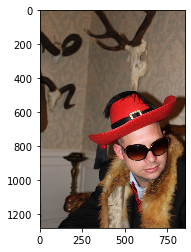

In [3]:
from skimage import io
import numpy as np
arr = io.imread('https://samples.fiji.sc/new-lenna.jpg')
ij.py.show(arr)

## Converting to Java: `ij.py.to_java`

The function `to_java` is capable of converting common Python and numpy data types into their Java/ImageJ equivalent.  There is one important nuance; converting a numpy array to java creates a java object that points to the numpy array.  This means that **changing the java object also changes the numpy array**.

Let's take a look at lists:

In [4]:
# Lists convert and handle simply
ex_list = [1, 2, 3, 4]
print(type(ex_list))
java_list = ij.py.to_java(ex_list)
print(type(java_list))

<class 'list'>
<class 'jnius.reflect.java.util.ArrayList'>


A java list can be accessed the same as a python list. Changing values in the python list does not change values in the java_list

In [5]:
ex_list[0] = 4
java_list[0]

1

By contrast, ops can operate on numpy arrays and change them, though you need to wrap the arrays in `to_java` first.

In [6]:
import numpy as np
arr1 = np.array([[1, 2], [3, 4]])
arr2 = np.array([[5, 6], [7, 8]])
arr_output = ij.py.new_numpy_image(arr1)

ij.op().run('multiply', ij.py.to_java(arr_output), ij.py.to_java(arr1), ij.py.to_java(arr2))
arr_output

array([[ 5, 12],
       [21, 32]])

### Technical note for using ops on numpy arrays
Numpy arrays become `RandomAccessibleInterval`s and can substitute for `IterableInterval`s. 

In [7]:
print(type(ij.py.to_java(arr1)))

<class 'jnius.reflect.net/imglib2/python/ReferenceGuardingRandomAccessibleInterval'>


If you need to trouble shoot op workings, look for implementations that use only `IterableInterval`s or `RandomAccessibleInterval`s. To find the implementations use the `print(ij.op().help())` function.

For the multiply function the implementation we used is second to last (`net.imagej.ops.math.IIToRAIOutputII$Multiply`)

In [8]:
# Print is required to render newlines
print(ij.op().help('multiply'))

Available operations:
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyByte(
		ArrayImg arg,
		byte value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyDouble(
		ArrayImg arg,
		double value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyFloat(
		ArrayImg arg,
		float value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyInt(
		ArrayImg arg,
		int value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyLong(
		ArrayImg arg,
		long value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyShort(
		ArrayImg arg,
		short value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyUnsignedByte(
		ArrayImg arg,
		byte value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyUnsignedInt(
		ArrayImg arg,
		int value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyUnsignedLong(
		ArrayImg arg,
		long value)
	(Arr

### Process numpy arrays in IJ
`to_java` also works to convert into ImageJ types. Let's grab an image:

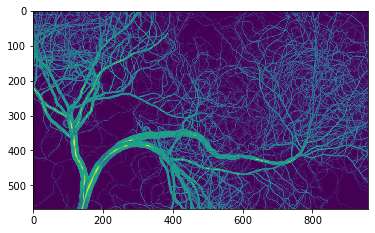

In [9]:
# Import an image with scikit-image.
# NB: Blood vessel image from: https://www.fi.edu/heart/blood-vessels
from skimage import io
url = 'https://www.fi.edu/sites/fi.live.franklinds.webair.com/files/styles/featured_large/public/General_EduRes_Heart_BloodVessels_0.jpg'
arr3 = io.imread(url)
arr3 = np.mean(arr3, axis=2)
ij.py.show(arr3)

Any `Op` that requires a `RandomAccessibleInterval` can run on a numpy array that has been passed to `to_java`.  Remember that this method creates a `view`, meaning that the `Op` is **modifying** the underlying Python object:

Let's run a [Difference of Gaussians](https://en.wikipedia.org/wiki/Difference_of_Gaussians) on our numpy image using ImageJ:

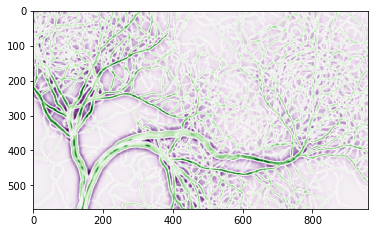

In [10]:
result = np.zeros(arr3.shape)
# these sigmas will be nice for the larger sections
sigma1 = 8
sigma2 = 2
# note the use of to_java on arr3 and result to turn the numpy images into RAIs
ij.op().filter().dog(
    ij.py.to_java(result),
    ij.py.to_java(arr3),
    sigma1,
    sigma2)
# purple highlights the edges of the vessels, green highlights the centers
ij.py.show(result, cmap = 'PRGn')

## Send an ImageJ image into NumPy: `ij.py.from_java`

`from_java` works in reverse of `to_java` and can be used to further process ImageJ data types with numpy, scikit-image, etc. 

Open an image from the url using the IJ scripting interface and then send it to a numpy array.

[INFO] Populating metadata
[INFO] Populating metadata


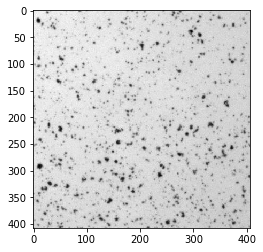

In [11]:
url_colony = 'https://wsr.imagej.net/images/Cell_Colony.jpg'

# Load the image
cell_colony = ij.io().open(url_colony)

# Send it to numpy
numpy_colony = ij.py.from_java(cell_colony)

# Display the image
ij.py.show(numpy_colony, cmap='gray')

## Convenience methods of `ij.py`
These methods can be helpful, especially if you do not know beforehand of which type your image is.

### `ij.py.dims`
This can be used to determine the dimensions of a numpy **or** ImageJ image:

In [12]:
# numpy image
arr4 = np.zeros([10, 10])
print(ij.py.dims(arr4))

# imagej image
img2 = ij.py.to_java(arr4)
print(ij.py.dims(img2))

(10, 10)
[10, 10]


### `ij.py.new_numpy_image`
Takes a single image argument, which can either be a numpy image or an imagej image

In [13]:
# create a new numpy image from a numpy image
arr5 = ij.py.new_numpy_image(arr4)
print(type(arr5))

# create a new numpy image from an imagej image
arr6 = ij.py.new_numpy_image(img2)
print(type(arr6))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Running macros, scripts, and plugins

### Using ImageJ macros: `ij.py.run_macro`
Running an IJ1 style macro is as simple as providing the macro code in a string, and the arguments in a dictionary to `run_macro`. Modify the following cell to print your name, age, and city.

In [14]:
macro = """
#@ String name
#@ int age
#@ String city
#@output Object greeting
greeting = "Hello " + name + ". You are " + age + " years old, and live in " + city + "."
"""
args = {
    'name': 'Chuckles',
    'age': 13,
    'city': 'Nowhere'
}
result = ij.py.run_macro(macro, args)
print(result.getOutput('greeting'))

[INFO] script:macro.ijm = [[greeting], [Hello Chuckles. You are 13 years old, and live in Nowhere.]]
Hello Chuckles. You are 13 years old, and live in Nowhere.


Running scripts in other languages is similar, but you also have to specify the file extension for the scripting language it is written in.

In [15]:
language_extension = 'ijm'
result_script = ij.py.run_script(language_extension, macro, args)
print(result_script.getOutput('greeting'))

[INFO] script:script.ijm = [[greeting], [Hello Chuckles. You are 13 years old, and live in Nowhere.]]
Hello Chuckles. You are 13 years old, and live in Nowhere.


### Example: Run a plugin: `ij.py.run_plugin`
Finally, running plugins works in the same manner as macros.  You simply enter the plugin name as a string and the arguments in a dict.  For the few plugins that use IJ2 style macros (i.e., explicit booleans in the recorder), set the optional variable `ij1_style=False`

This example works with IJ1 windows, opening images entirely within IJ and then getting the results.  Working with IJ1 windows requires importing another class, which is done using the jnius framework.  The jnius.autoclass function can import other java classes for similar purposes.

In [16]:
ij.py.run_macro("""run("Blobs (25K)");""")
blobs = ij.py.active_image_plus()
print(blobs)

<ij.ImagePlus at 0x21f1333c0a8 jclass=ij/ImagePlus jself=<LocalRef obj=0x9a7b1d8 at 0x21f1326cbd0>>


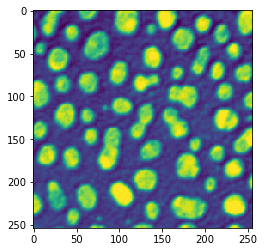

In [17]:
ij.py.show(blobs)

We can now run plugins that require open IJ1 windows

In [18]:
plugin = 'Mean'
args = { 
    'block_radius_x': 10,
    'block_radius_y': 10
}

ij.py.run_plugin(plugin, args)

Unrecognized command: "Mean"


<org.scijava.script.ScriptModule at 0x21f133471c8 jclass=org/scijava/script/ScriptModule jself=<LocalRef obj=0xde77f28 at 0x21f13c78db0>>

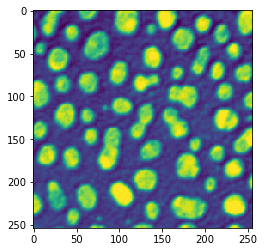

In [19]:
result = ij.py.active_image_plus()
result = ij.py.show(result)

You can list any active IJ1 windows with the following command.

In [20]:
print(ij.py.from_java(ij.window().getOpenWindows()))

['blobs.gif']


You can close any IJ1 windows through the following command.

In [21]:
ij.window().clear()
print(ij.py.from_java(ij.window().getOpenWindows()))

[]


## Visualizing large images

Before we begin: how much memory is Java using right now?

In [22]:
from jnius import autoclass
Runtime = autoclass('java.lang.Runtime')
def java_mem():
    rt = Runtime.getRuntime()
    mem_max = rt.maxMemory()
    mem_used = rt.totalMemory() - rt.freeMemory()
    return '{} of {} MB ({}%)'.format(
        int(mem_used / 2**20),
        int(mem_max / 2**20),
        int(100 * mem_used / mem_max))
java_mem()

'307 of 3609 MB (8%)'

Now let's open an obnoxiously huge synthetic dataset:

In [23]:
big_data = ij.scifio().datasetIO().open('lotsofplanes&lengths=512,512,16,1000,10000&axes=X,Y,Channel,Z,Time.fake')

How many total samples does this image have?

In [24]:
import numpy as np
dims = [big_data.dimension(d) for d in range(big_data.numDimensions())]
pix = np.prod(dims)
str(pix / 2**40) + " terapixels"

'-0.00146484375 terapixels'

And how much did memory usage in Java increase?

In [25]:
java_mem()

'1087 of 3609 MB (30%)'

Let's visualize this beast. First, we define a function for slicing out a single plane:

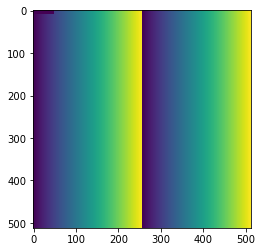

In [26]:
def plane(image, pos):
    while image.numDimensions() > 2:
        image = ij.op().transform().hyperSliceView(image, image.numDimensions() - 1, pos[-1])
        pos.pop()
    return ij.py.from_java(image)

ij.py.show(plane(big_data, [0, 0, 0]))

But we can do better. Let's provide some interaction. First, a function to extract the _non-planar_ axes as a dict:

In [27]:
from jnius import autoclass, cast
CalibratedAxis = autoclass('net.imagej.axis.CalibratedAxis')

def axes(dataset):
    axes = {}
    for d in range(2, dataset.numDimensions()):
        axis = cast(CalibratedAxis, dataset.axis(d))
        label = axis.type().getLabel()
        length = dataset.dimension(d)
        axes[label] = length
    return axes

axes(big_data)

{'Channel': 16, 'Z': 1000, 'Time': 10000}

And now, we have the tools we need to use `ipywidgets.interact` for any N-dimensional image!

In [28]:
import ipywidgets, matplotlib

widgets = {}
for label, length in axes(big_data).items():
    widgets[label] = ipywidgets.IntSlider(description=label, max=length-1)

def f(**kwargs):
    matplotlib.pyplot.imshow(plane(big_data, list(kwargs.values())), cmap='gray')
ipywidgets.interact(f, **widgets);

interactive(children=(IntSlider(value=0, description='Channel', max=15), IntSlider(value=0, description='Z', m…

## Troubleshooting

### I can't pass my numpy image through to an `Op`

`ij.py` is really good at converting numpy images into `RandomAccessibleInterval`s. However many `Op`s, like `addPoissonNoise`, take other forms of ImageJ images, like `IterableInterval`.

In [29]:
print(ij.op().help('filter.addPoissonNoise'))

Available operations:
	(RealType out) =
	net.imagej.ops.filter.addPoissonNoise.AddPoissonNoiseRealType(
		RealType out,
		RealType in,
		long seed?)
	(IterableInterval out) =
	net.imagej.ops.filter.addPoissonNoise.AddPoissonNoiseMap(
		IterableInterval out,
		IterableInterval in)


We can't call this `Op` on a numpy array since it is a specialized type of `RandomAccessibleInterval`, which does not extend `IterableInterval`.

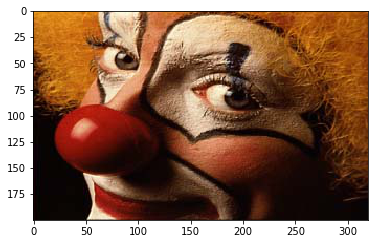

<class 'jnius.reflect.net/imglib2/python/ReferenceGuardingRandomAccessibleInterval'>


In [30]:
# Create a numpy image using scikit
arr7 = io.imread('https://imagej.net/images/clown.jpg')

ij.py.show(arr7)
print(type(ij.py.to_java(arr7)))

We can fix this by using `transform.flatIterableView` on both the input and output, which will convert the `ReferenceGuardedRandomAccessibleInterval`s into `IterableInterval`s, allowing us to pass our numpy image into `addPoissonNoise`:

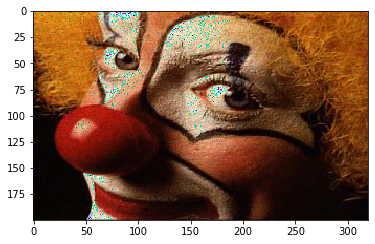

In [31]:
result = ij.py.new_numpy_image(arr7)

imgIterable = ij.op().transform().flatIterableView(ij.py.to_java(arr7))
resIterable = ij.op().transform().flatIterableView(ij.py.to_java(result))

ij.op().filter().addPoissonNoise(resIterable, imgIterable)

ij.py.show(result)

Uh oh.

### Clipping input data to the valid range for imshow with RGB data ([0..1] for floats of [0..255] for integers

This message is given either because (as described in the warning)

* The data consists of floats that are outside the range of [0..1]. This is pretty common and definitely is the case as to why the above data looks so bad.
* The data consists of ints that are outside the range [0..255].

Let's find out which is the culprit by checking some values of `result`:

In [32]:
# grab the RGB values in a line from [0][5] to [0][10] in our image
print(result[0][5:10])

[[254 179  45]
 [  5 172  54]
 [254 156  44]
 [  7 167  35]
 [223 160  39]]


Thus we not only have floats outside of [0..1] but also values outside of [0..255]; we are faulty of both points in the warning. We can fix this by first [clipping](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.clip.html) the entire array within the integer range, then cast to `uint8` so that the float range no longer applies:

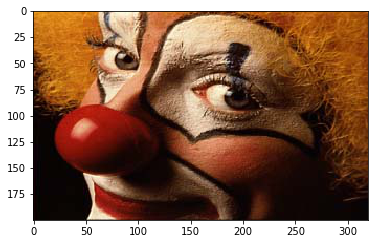

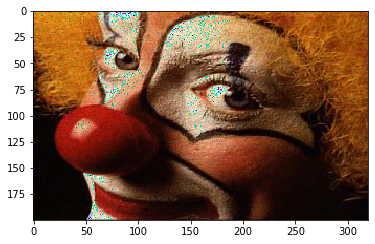

In [33]:
ij.py.show(arr7.astype(int))
       
result = np.clip(result, 0, 255)
ij.py.show(result.astype(np.uint8))

Now our noisy image displays nicely alongside the original. Note that depending on your data this might not be the right path for you, but using `clip` and `astype` are great tools for rearranging your data within these bounds.